In [2]:
# import the necessary packages
import numpy as np
import cv2
from matplotlib import pyplot as plt
import imutils

In [3]:
from os import listdir
from os.path import isfile, join
images_paths = sorted([f for f in listdir('../images') if isfile(join('../images', f))])

In [66]:
def bound_box(image_path):
    # load the image and convert it to grayscale
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    """print(image.shape)
    plt.imshow(gray, 'gray')"""

    # compute the Scharr gradient magnitude representation of the images
    # in both the x and y direction using OpenCV 2.4
    ddepth = cv2.cv.CV_32F if imutils.is_cv2() else cv2.CV_32F
    gradX = cv2.Sobel(gray, ddepth=ddepth, dx=1, dy=0, ksize=-1)
    gradY = cv2.Sobel(gray, ddepth=ddepth, dx=0, dy=1, ksize=-1)
    # subtract the y-gradient from the x-gradient
    gradient = cv2.subtract(gradX, gradY)
    gradient = cv2.convertScaleAbs(gradient)

    #image_derivative = np.maximum(image_horizontal_derivative, image_vertical_derivative)

    """plt.figure()
    plt.imshow(image_horizontal_derivative, 'gray')"""
    
    ret2,thresh = cv2.threshold(gradient,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    #kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (20, 20))
    #closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 100))
    opened = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 20))
    closed1 = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (20, 1))
    opened1 = cv2.morphologyEx(closed1, cv2.MORPH_OPEN, kernel)
    
    #kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (11, 1))
    #dilated = cv2.dilate(opened1, kernel, iterations=5)
    
    cnts = cv2.findContours(opened1.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #print(cnts)
    cnts = imutils.grab_contours(cnts)
    c = sorted(cnts, key = cv2.contourArea, reverse = True)[0]
    # compute the rotated bounding box of the largest contour
    rect = cv2.minAreaRect(c)
    #print(rect)
    box = cv2.cv.BoxPoints(rect) if imutils.is_cv2() else cv2.boxPoints(rect)
    box = np.int0(box)
    #print(box)
    # draw a bounding box arounded the detected barcode and display the
    # image
    image_bb = image.copy()
    cv2.drawContours(image_bb, [box], -1, (0, 255, 0), 3)
    plt.figure()
    plt.imshow(image_bb, 'gray')
    
    coordinates_source = box.astype('float32')
    min_width = coordinates_source[:,0].min()
    min_height = coordinates_source[:,1].min()
    max_width = coordinates_source[:,0].max()
    max_height = coordinates_source[:,1].max()
    def normalize(value, axis=0):
        if axis==0:  # Horizontal dimension
            return min_width if (value-min_width<max_width-value) \
                             else max_width
        elif axis==1:  # Vertical dimension
            return min_height if (value-min_height<max_height-value) \
                              else max_height
    coordinates_source = np.array(sorted([tuple(v) for v in coordinates_source], key=lambda t: (normalize(t[1], axis=1),
                                                                                                normalize(t[0], axis=0))))
    print(coordinates_source)
    def dist(point1, point2):
        return np.sqrt(np.sum((point1-point2)**2))
    destination_height = int(max([dist(coordinates_source[0],coordinates_source[2]),
                             dist(coordinates_source[1],coordinates_source[3])]))
    destination_width = int(max([dist(coordinates_source[0],coordinates_source[1]),
                             dist(coordinates_source[2],coordinates_source[3])]))
    coordinates_destination = np.array([[0, 0],
                                        [destination_width-1, 0],
                                        [0, destination_height-1],
                                        [destination_width-1, destination_height-1]], dtype='float32')
    # Computing the trasformation, i.e. homography. Warping.
    H = cv2.getPerspectiveTransform(coordinates_source, coordinates_destination)
    # Applying the trasformation
    gray1 = cv2.warpPerspective(gray, H, (destination_width, destination_height))
    plt.figure()
    plt.imshow(gray1, 'gray')

[[ 411.  254.]
 [1275.  250.]
 [ 416. 1134.]
 [1279. 1130.]]
Wall time: 295 ms


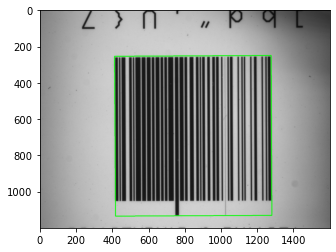

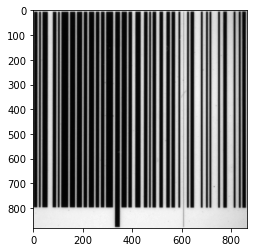

In [5]:
%%time
bound_box(f'../images/{images_paths[0]}')

[[ 360.  281.]
 [1226.  281.]
 [ 360. 1088.]
 [1226. 1088.]]
Wall time: 272 ms


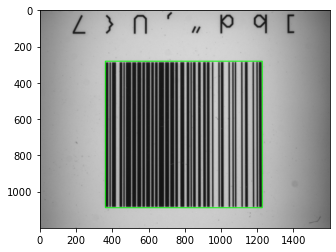

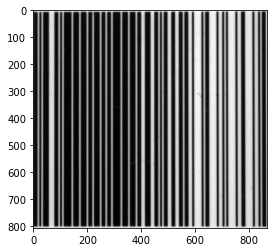

In [6]:
%%time
bound_box(f'../images/{images_paths[1]}')

[[ 210.  236.]
 [1022.  232.]
 [ 213.  770.]
 [1025.  766.]]
Wall time: 221 ms


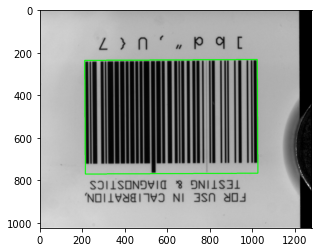

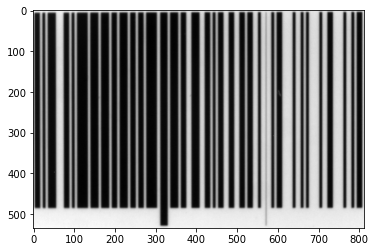

In [7]:
%%time
bound_box(f'../images/{images_paths[2]}')

[[141. 251.]
 [952. 251.]
 [141. 745.]
 [952. 745.]]
Wall time: 227 ms


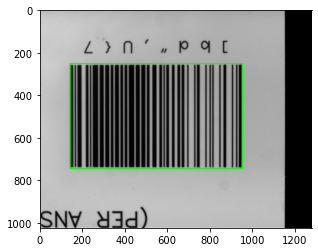

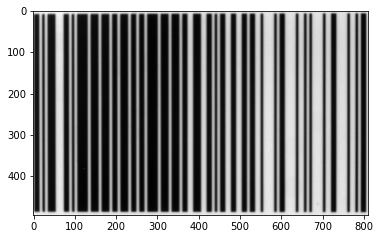

In [8]:
%%time
bound_box(f'../images/{images_paths[3]}')

[[346. 165.]
 [883. 165.]
 [346. 734.]
 [883. 734.]]
Wall time: 218 ms


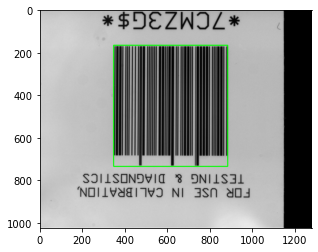

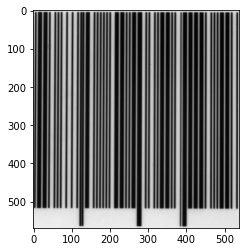

In [9]:
%%time
bound_box(f'../images/{images_paths[4]}')

[[354. 243.]
 [894. 245.]
 [352. 767.]
 [893. 769.]]


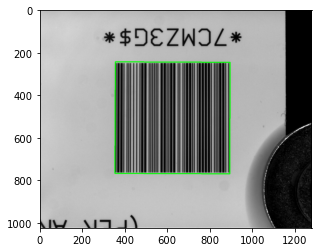

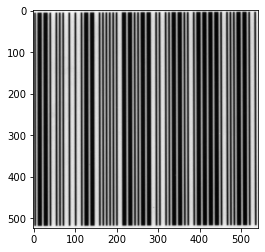

In [10]:
bound_box(f'../images/{images_paths[5]}')

[[ 174.  282.]
 [1082.  279.]
 [ 176.  851.]
 [1083.  849.]]


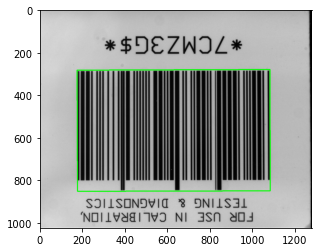

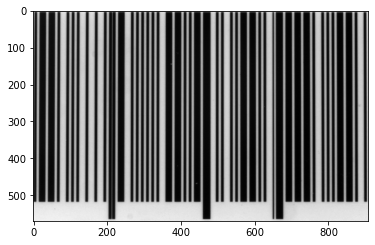

In [11]:
bound_box(f'../images/{images_paths[6]}')

[[ 163.  267.]
 [1074.  269.]
 [ 162.  792.]
 [1073.  794.]]


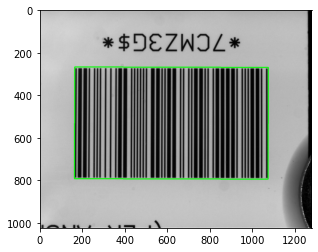

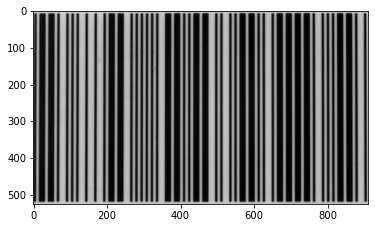

In [12]:
bound_box(f'../images/{images_paths[7]}')

[[ 163.  267.]
 [1074.  269.]
 [ 162.  792.]
 [1073.  794.]]


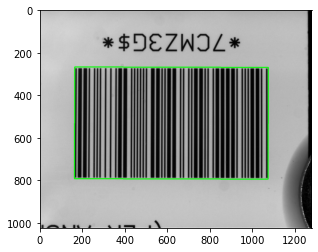

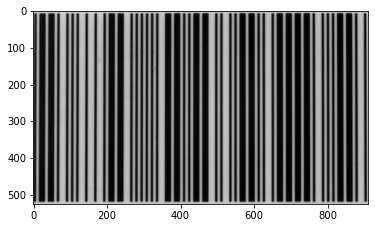

In [13]:
bound_box(f'../images/{images_paths[7]}')

[[342. 331.]
 [955. 336.]
 [339. 782.]
 [952. 787.]]


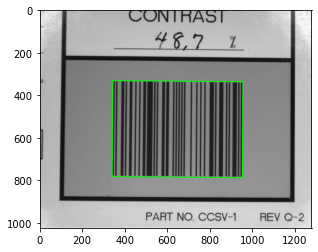

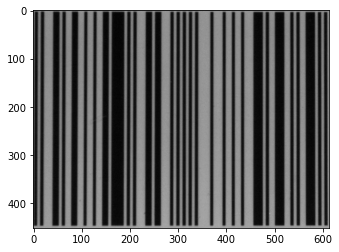

In [14]:
bound_box(f'../images/{images_paths[8]}')

[[354. 250.]
 [962. 257.]
 [348. 723.]
 [956. 731.]]


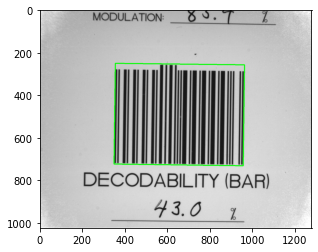

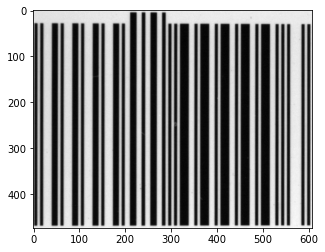

In [15]:
bound_box(f'../images/{images_paths[9]}')

In [16]:
print(f'../images/{images_paths[10]}')

images/EAN-UPC-DEFECTS IMGB.BMP


In [17]:
#bound_box(f'../images/{images_paths[10]}')

[[271. 279.]
 [937. 277.]
 [272. 761.]
 [938. 760.]]


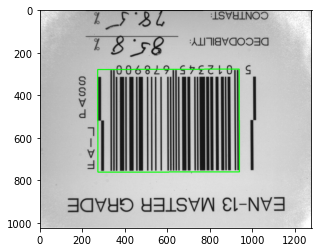

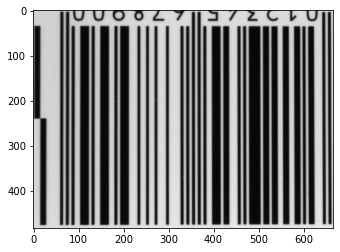

In [18]:
bound_box(f'../images/{images_paths[11]}')

In [19]:
#bound_box(f'../images/{images_paths[12]}')

[[ 109.  116.]
 [1276.  114.]
 [ 110.  316.]
 [1277.  314.]]


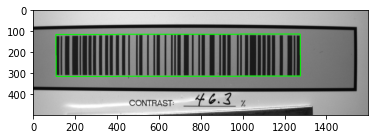

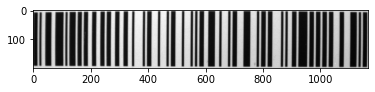

In [20]:
bound_box(f'../images/{images_paths[13]}')

[[ 111.  116.]
 [1278.  118.]
 [ 110.  314.]
 [1277.  316.]]


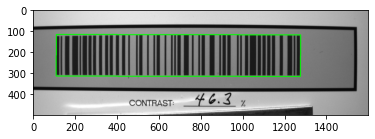

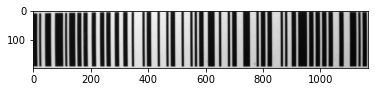

In [67]:
bound_box(f'../images/{images_paths[13]}')

[[ 173.  138.]
 [1334.  142.]
 [ 172.  354.]
 [1333.  358.]]


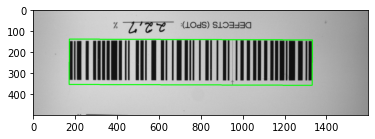

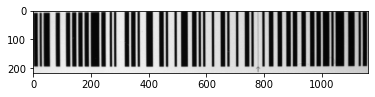

In [21]:
bound_box(f'../images/{images_paths[14]}')

[[ 174.  142.]
 [1335.  142.]
 [ 174.  341.]
 [1335.  341.]]


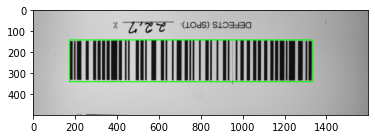

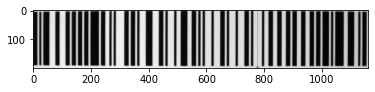

In [68]:
bound_box(f'../images/{images_paths[14]}')

[[ 186.  147.]
 [1366.  134.]
 [ 189.  364.]
 [1369.  351.]]


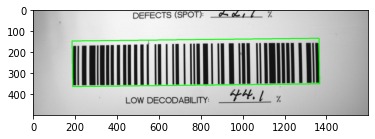

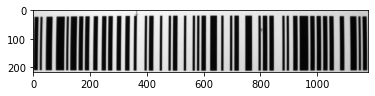

In [23]:
bound_box(f'../images/{images_paths[15]}')

[[ 187.  165.]
 [1367.  151.]
 [ 190.  366.]
 [1370.  352.]]


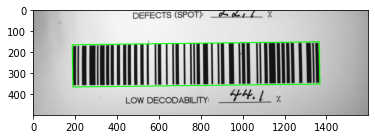

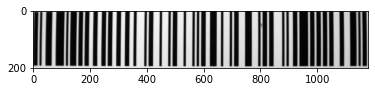

In [69]:
bound_box(f'../images/{images_paths[15]}')

[[ 164.  137.]
 [1433.  137.]
 [ 164.  336.]
 [1433.  336.]]


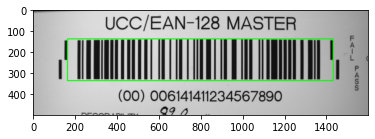

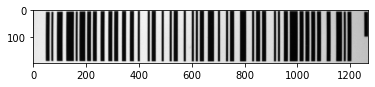

In [27]:
bound_box(f'../images/{images_paths[16]}')

[[ 207.  142.]
 [1334.  120.]
 [ 212.  389.]
 [1338.  366.]]


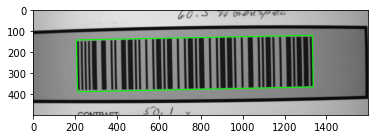

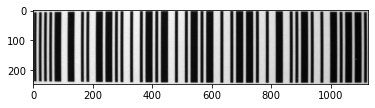

In [28]:
bound_box(f'../images/{images_paths[17]}')

[[ 208.  143.]
 [1335.  122.]
 [ 213.  389.]
 [1339.  367.]]


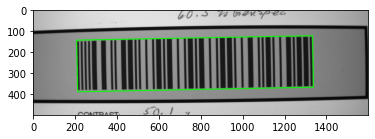

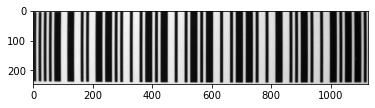

In [70]:
bound_box(f'../images/{images_paths[17]}')

[[ 211.  112.]
 [1342.  119.]
 [ 209.  372.]
 [1340.  379.]]


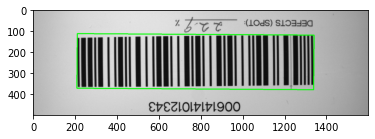

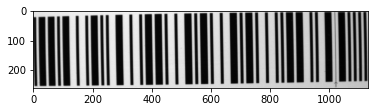

In [29]:
bound_box(f'../images/{images_paths[18]}')  ###############

[[ 210.  126.]
 [1341.  116.]
 [ 212.  373.]
 [1343.  363.]]


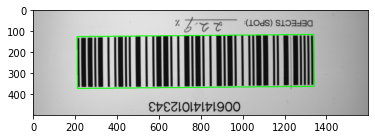

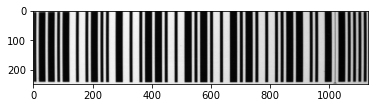

In [71]:
bound_box(f'../images/{images_paths[18]}')

[[ 242.   41.]
 [1370.   47.]
 [ 241.  299.]
 [1368.  306.]]


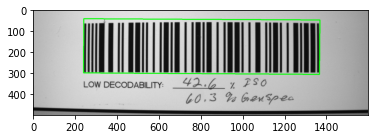

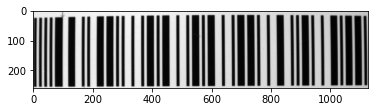

In [30]:
bound_box(f'../images/{images_paths[19]}')

[[ 243.   56.]
 [1370.   57.]
 [ 242.  301.]
 [1369.  303.]]


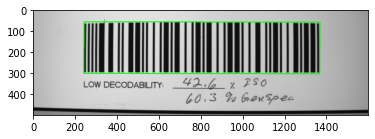

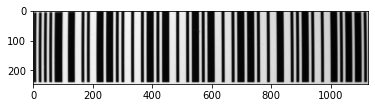

In [72]:
bound_box(f'../images/{images_paths[19]}')

[[ 259.  137.]
 [1390.  125.]
 [ 262.  385.]
 [1392.  374.]]


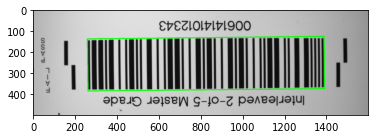

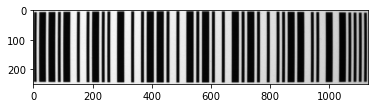

In [31]:
bound_box(f'../images/{images_paths[20]}')

In [32]:
print(f'../images/{images_paths[21]}')

images/TestChart.xls


In [33]:
#bound_box(f'../images/{images_paths[21]}')

[[189. 208.]
 [871. 204.]
 [192. 645.]
 [873. 641.]]


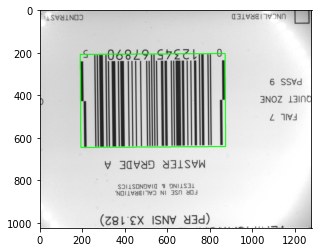

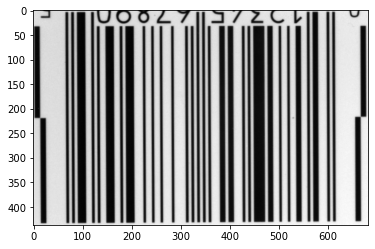

In [34]:
bound_box(f'../images/{images_paths[22]}')

[[190. 211.]
 [871. 205.]
 [194. 647.]
 [876. 640.]]


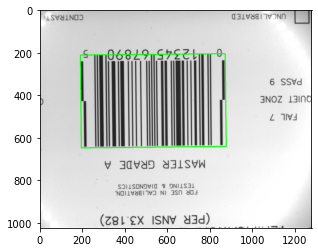

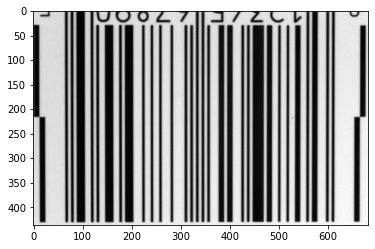

In [73]:
bound_box(f'../images/{images_paths[22]}')

[[324. 284.]
 [879. 287.]
 [322. 740.]
 [876. 743.]]


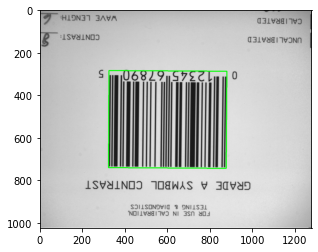

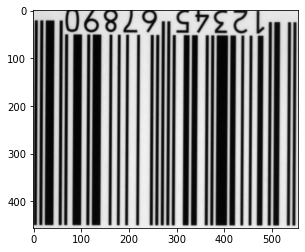

In [35]:
bound_box(f'../images/{images_paths[23]}')

[[359. 298.]
 [911. 308.]
 [351. 734.]
 [903. 744.]]


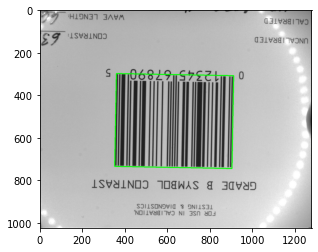

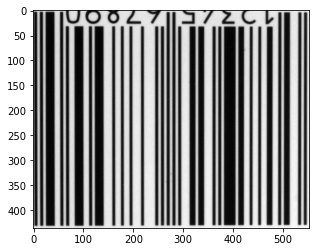

In [36]:
bound_box(f'../images/{images_paths[24]}')

[[367. 302.]
 [918. 305.]
 [365. 736.]
 [917. 738.]]


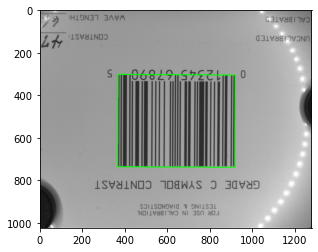

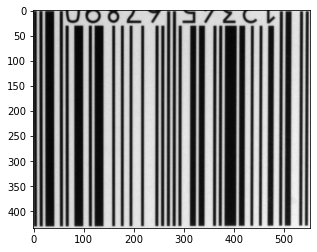

In [37]:
bound_box(f'../images/{images_paths[25]}')

[[307. 283.]
 [857. 304.]
 [291. 711.]
 [841. 732.]]


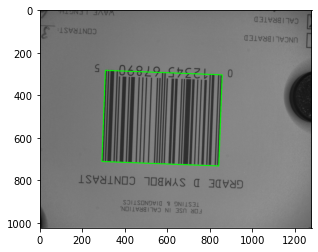

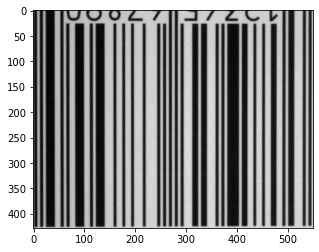

In [38]:
bound_box(f'../images/{images_paths[26]}')

[[344. 290.]
 [893. 299.]
 [336. 722.]
 [886. 731.]]


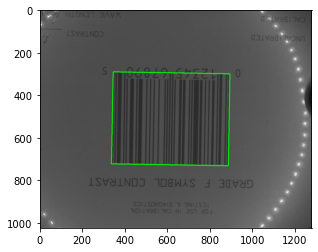

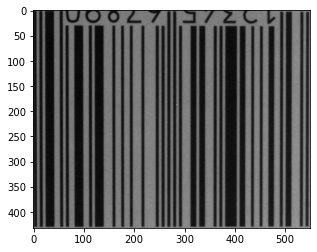

In [39]:
bound_box(f'../images/{images_paths[27]}')

[[337. 293.]
 [891. 300.]
 [331. 730.]
 [885. 737.]]


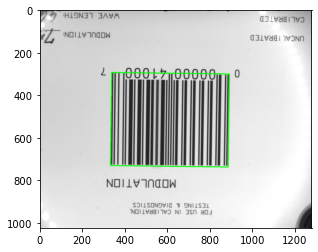

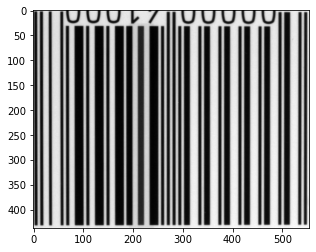

In [40]:
bound_box(f'../images/{images_paths[28]}')

[[336. 297.]
 [891. 307.]
 [329. 734.]
 [883. 744.]]


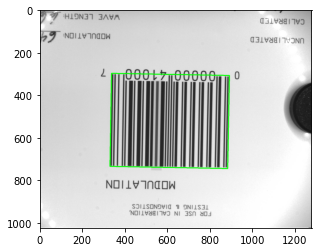

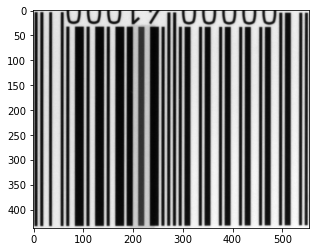

In [41]:
bound_box(f'../images/{images_paths[29]}')

[[333. 309.]
 [888. 319.]
 [325. 745.]
 [880. 756.]]


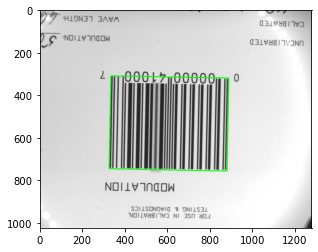

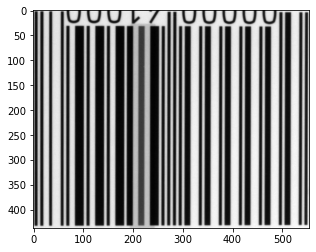

In [42]:
bound_box(f'../images/{images_paths[30]}')

[[343. 278.]
 [895. 293.]
 [330. 733.]
 [882. 749.]]


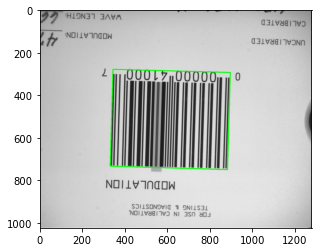

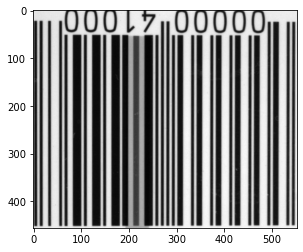

In [43]:
bound_box(f'../images/{images_paths[31]}')

[[342. 287.]
 [895. 288.]
 [342. 724.]
 [895. 724.]]


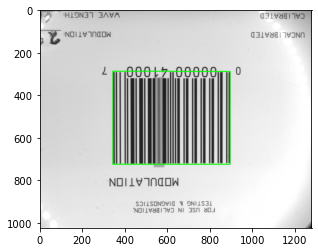

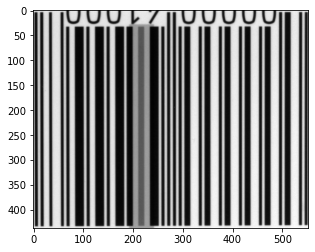

In [44]:
bound_box(f'../images/{images_paths[32]}')

[[355. 295.]
 [908. 301.]
 [350. 754.]
 [903. 760.]]


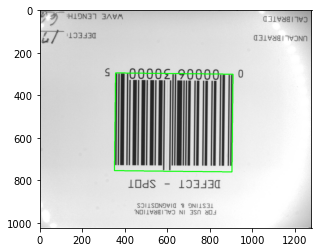

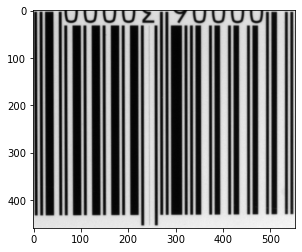

In [45]:
bound_box(f'../images/{images_paths[34]}')

[[354. 286.]
 [908. 294.]
 [348. 742.]
 [901. 750.]]


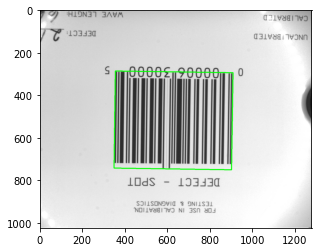

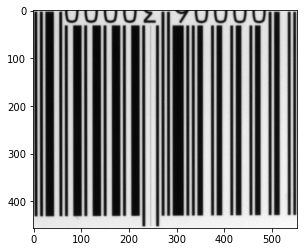

In [46]:
bound_box(f'../images/{images_paths[35]}')

[[341. 290.]
 [894. 288.]
 [343. 748.]
 [896. 746.]]


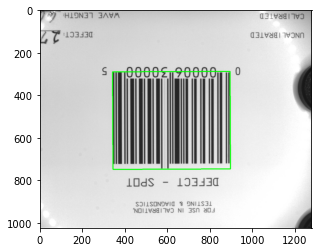

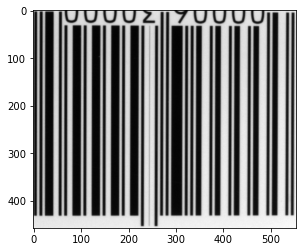

In [47]:
bound_box(f'../images/{images_paths[36]}')

[[329. 296.]
 [881. 297.]
 [329. 754.]
 [881. 754.]]


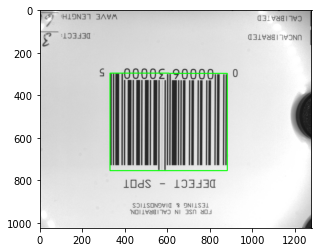

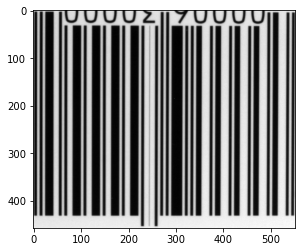

In [48]:
bound_box(f'../images/{images_paths[37]}')

[[341. 296.]
 [895. 298.]
 [340. 755.]
 [894. 756.]]


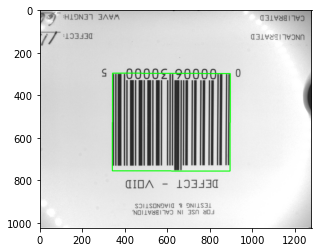

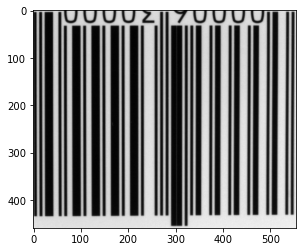

In [49]:
bound_box(f'../images/{images_paths[38]}')

[[345. 289.]
 [899. 296.]
 [340. 747.]
 [893. 753.]]


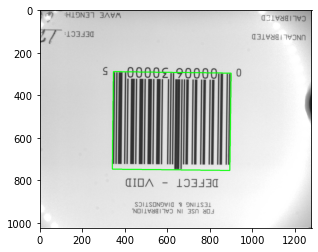

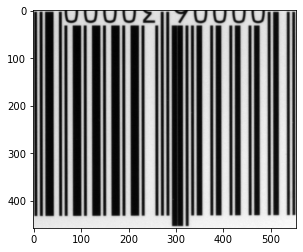

In [50]:
bound_box(f'../images/{images_paths[39]}')

[[309. 298.]
 [863. 301.]
 [307. 757.]
 [860. 760.]]


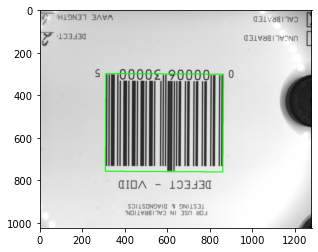

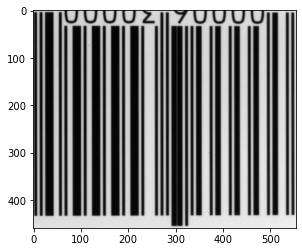

In [51]:
bound_box(f'../images/{images_paths[40]}')

[[299. 292.]
 [853. 290.]
 [300. 748.]
 [854. 747.]]


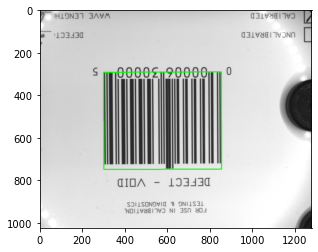

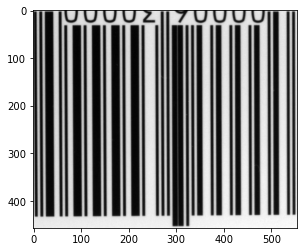

In [52]:
bound_box(f'../images/{images_paths[41]}')

[[297. 289.]
 [850. 289.]
 [297. 747.]
 [850. 747.]]


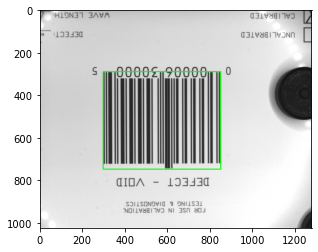

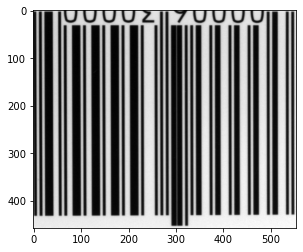

In [53]:
bound_box(f'../images/{images_paths[42]}')

[[291. 284.]
 [845. 284.]
 [291. 721.]
 [845. 721.]]


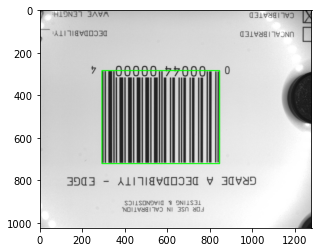

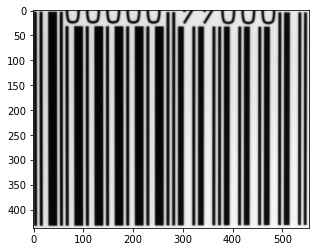

In [54]:
bound_box(f'../images/{images_paths[43]}')

[[291. 284.]
 [845. 284.]
 [291. 721.]
 [845. 721.]]


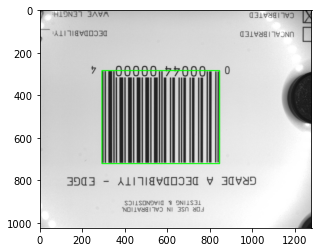

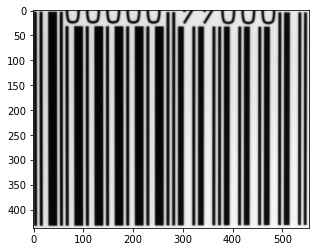

In [55]:
bound_box(f'../images/{images_paths[43]}')

[[301. 290.]
 [855. 294.]
 [298. 728.]
 [852. 732.]]


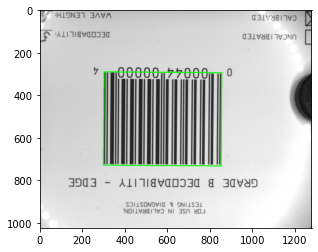

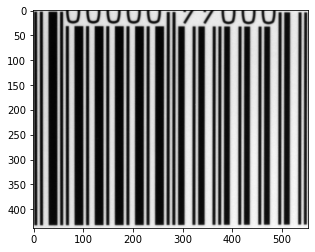

In [56]:
bound_box(f'../images/{images_paths[44]}')

[[289. 302.]
 [844. 305.]
 [288. 740.]
 [842. 743.]]


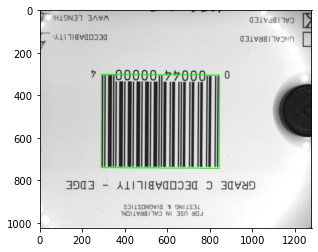

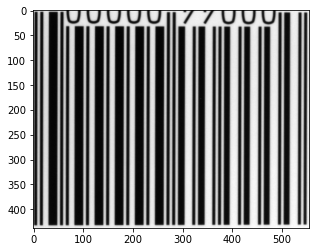

In [57]:
bound_box(f'../images/{images_paths[45]}')

[[273. 291.]
 [828. 298.]
 [268. 729.]
 [823. 736.]]


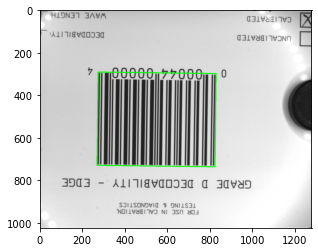

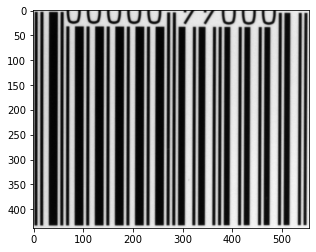

In [58]:
bound_box(f'../images/{images_paths[46]}')

[[269. 299.]
 [824. 305.]
 [264. 736.]
 [819. 742.]]


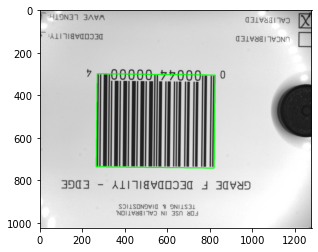

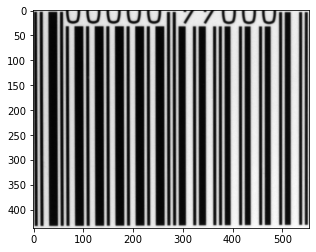

In [59]:
bound_box(f'../images/{images_paths[47]}')

[[262. 278.]
 [817. 284.]
 [257. 735.]
 [812. 741.]]


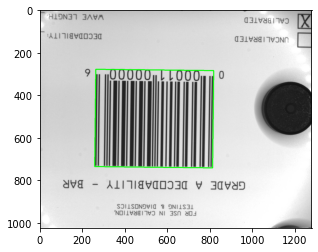

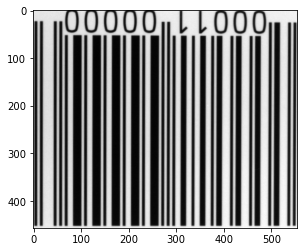

In [60]:
bound_box(f'../images/{images_paths[48]}')

[[266. 298.]
 [821. 305.]
 [261. 736.]
 [816. 743.]]


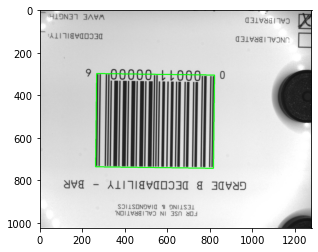

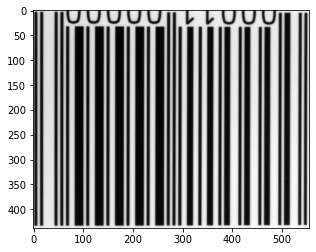

In [61]:
bound_box(f'../images/{images_paths[49]}')

[[291. 256.]
 [846. 263.]
 [285. 713.]
 [840. 720.]]


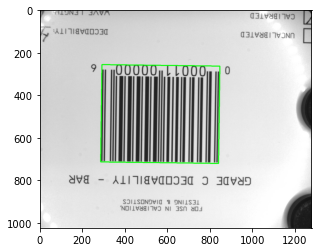

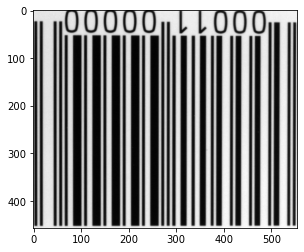

In [62]:
bound_box(f'../images/{images_paths[50]}')

[[293. 286.]
 [848. 295.]
 [286. 723.]
 [841. 732.]]


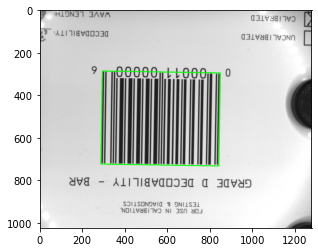

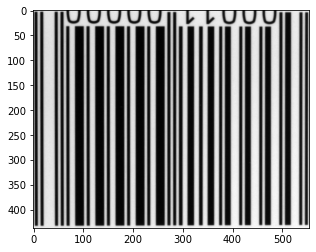

In [63]:
bound_box(f'../images/{images_paths[51]}')

[[307. 288.]
 [861. 291.]
 [305. 726.]
 [859. 728.]]


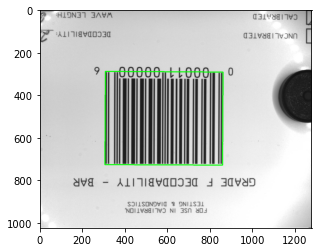

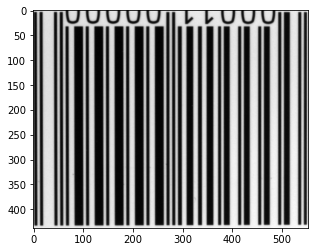

In [64]:
bound_box(f'../images/{images_paths[52]}')

[[108.  40.]
 [243.  40.]
 [108. 151.]
 [243. 151.]]
Wall time: 97.6 ms


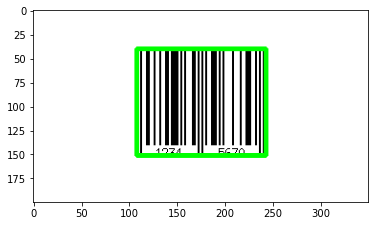

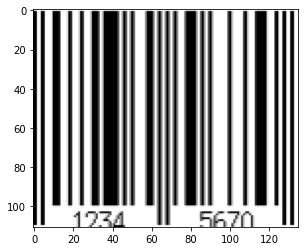

In [65]:
%%time
bound_box('other images/1.png')